# **Importamos librerias**

In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# **Activamos la TPU**

In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


# **Importamos la data**

In [3]:

# conectamos al drive
drive.mount('/content/drive')

# Definimos el directorio
dir_data_kaggle='./drive/MyDrive/lwpwq/data'

# extraemos la data

dyn_train=np.load(dir_data_kaggle+'/dyn_train_data_mb.npy', allow_pickle=True)
dyn_test=np.load(dir_data_kaggle+'/dyn_test_data_mb.npy', allow_pickle=True)


stat_train=np.load(dir_data_kaggle+'/stat_train_data_mb.npy', allow_pickle=True)
stat_test=np.load(dir_data_kaggle+'/stat_test_data_mb.npy', allow_pickle=True)


target_train=np.load(dir_data_kaggle+'/target_train_data_mb.npy', allow_pickle=True)
target_test=np.load(dir_data_kaggle+'/target_test_data_mb.npy', allow_pickle=True)


Mounted at /content/drive


# **Acomodamos la data**

In [4]:
# escalamos la data

target_train=(target_train-0.5)/5.5

target_test=(target_test-0.5)/5.5

# **Construimos el modelo**

In [5]:
# definimos las dimensiones

stat_input_shape=stat_train.shape[1]
dyn_input_shape=dyn_train.shape[1:]

with strategy.scope():


  input_stat= tf.keras.layers.Input(stat_input_shape)
  input_dyn= tf.keras.layers.Input(dyn_input_shape)

  masking_layer=keras.layers.Masking(mask_value=-1)

  masking_dyn=masking_layer(input_dyn)

  conv_layers= tf.keras.Sequential([

  keras.layers.Conv1D(filters=64, kernel_size=3, padding='same'),
  keras.layers.BatchNormalization(),
  keras.layers.ReLU(),

  keras.layers.Conv1D(filters=64, kernel_size=3, padding='same'),
  keras.layers.BatchNormalization(),
  keras.layers.ReLU(),

  keras.layers.GlobalAveragePooling1D(),

                                                               ])
  conv_stack=conv_layers(masking_dyn)


  concat = tf.keras.layers.concatenate([input_stat, conv_stack])

  dense_1=keras.layers.Dense(units=8, activation='sigmoid')(concat)

  dense_2= keras.layers.Dense(units=8, activation='sigmoid')(dense_1)

  output=  keras.layers.Dense(units=1, activation='sigmoid')(dense_2)

  model = tf.keras.Model(inputs=[input_stat, input_dyn], outputs=[output])


  # compilamos

  model.compile(
    optimizer='rmsprop',
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()],
      )


In [6]:
# definimos algunos parametros de entrenamiento

epochs = 200
batch_size = 320

callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_model.keras', save_best_only=True, monitor='val_loss'),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=10, min_lr=10e-8),

    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1),
]


In [7]:


# entrenamos

history = model.fit(
    x=(stat_train,dyn_train),
    y=target_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/200
4/4 [==============================] - 15s 3s/step - loss: 0.0604 - root_mean_squared_error: 0.2459 - val_loss: 0.0509 - val_root_mean_squared_error: 0.2256 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 2s 482ms/step - loss: 0.0498 - root_mean_squared_error: 0.2232 - val_loss: 0.0474 - val_root_mean_squared_error: 0.2178 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 1s 468ms/step - loss: 0.0450 - root_mean_squared_error: 0.2121 - val_loss: 0.0448 - val_root_mean_squared_error: 0.2116 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 1s 446ms/step - loss: 0.0418 - root_mean_squared_error: 0.2045 - val_loss: 0.0428 - val_root_mean_squared_error: 0.2070 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 1s 431ms/step - loss: 0.0395 - root_mean_squared_error: 0.1988 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2031 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 1s 396ms/step - loss: 0.0379 - 

# **Testeamos el modelo**

In [8]:
# testeamos el mejor modelo

model = keras.models.load_model('best_model.keras')

test_loss, test_acc = model.evaluate((stat_test,dyn_test), target_test)

print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')


31/31 [==============================] - 1s 27ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863
Test accuracy: 0.18627938628196716
Test loss: 0.03470000997185707


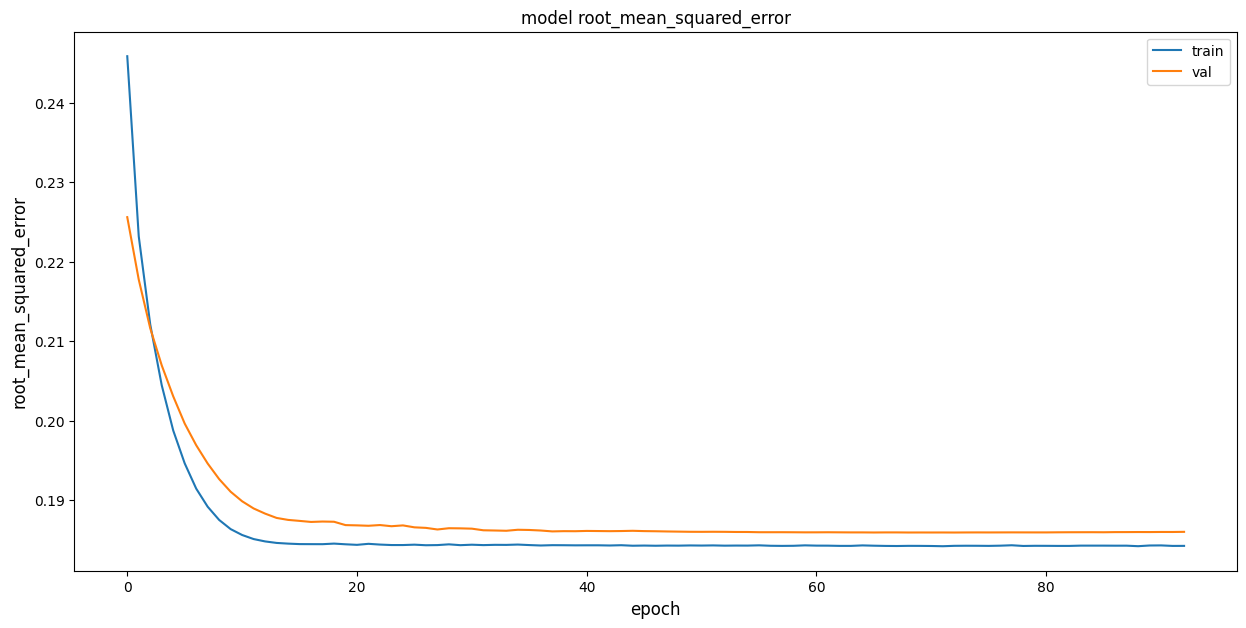

In [9]:
# visualizamos el entrenamiento

metric = 'root_mean_squared_error'

plt.figure(figsize=(15,7))

plt.plot(history.history[metric])
plt.plot(history.history['val_' + metric])

plt.title('model ' + metric)
plt.ylabel(metric, fontsize='large')
plt.xlabel('epoch', fontsize='large')
plt.legend(['train', 'val'], loc='best')
plt.show()
plt.close()
